In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
image_path = "/kaggle/input/flickr8k/Images"
dir_Flickr_text = "/kaggle/input/flickr8k/captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [4]:
captions_df = pd.read_csv(dir_Flickr_text)


In [5]:
captions_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

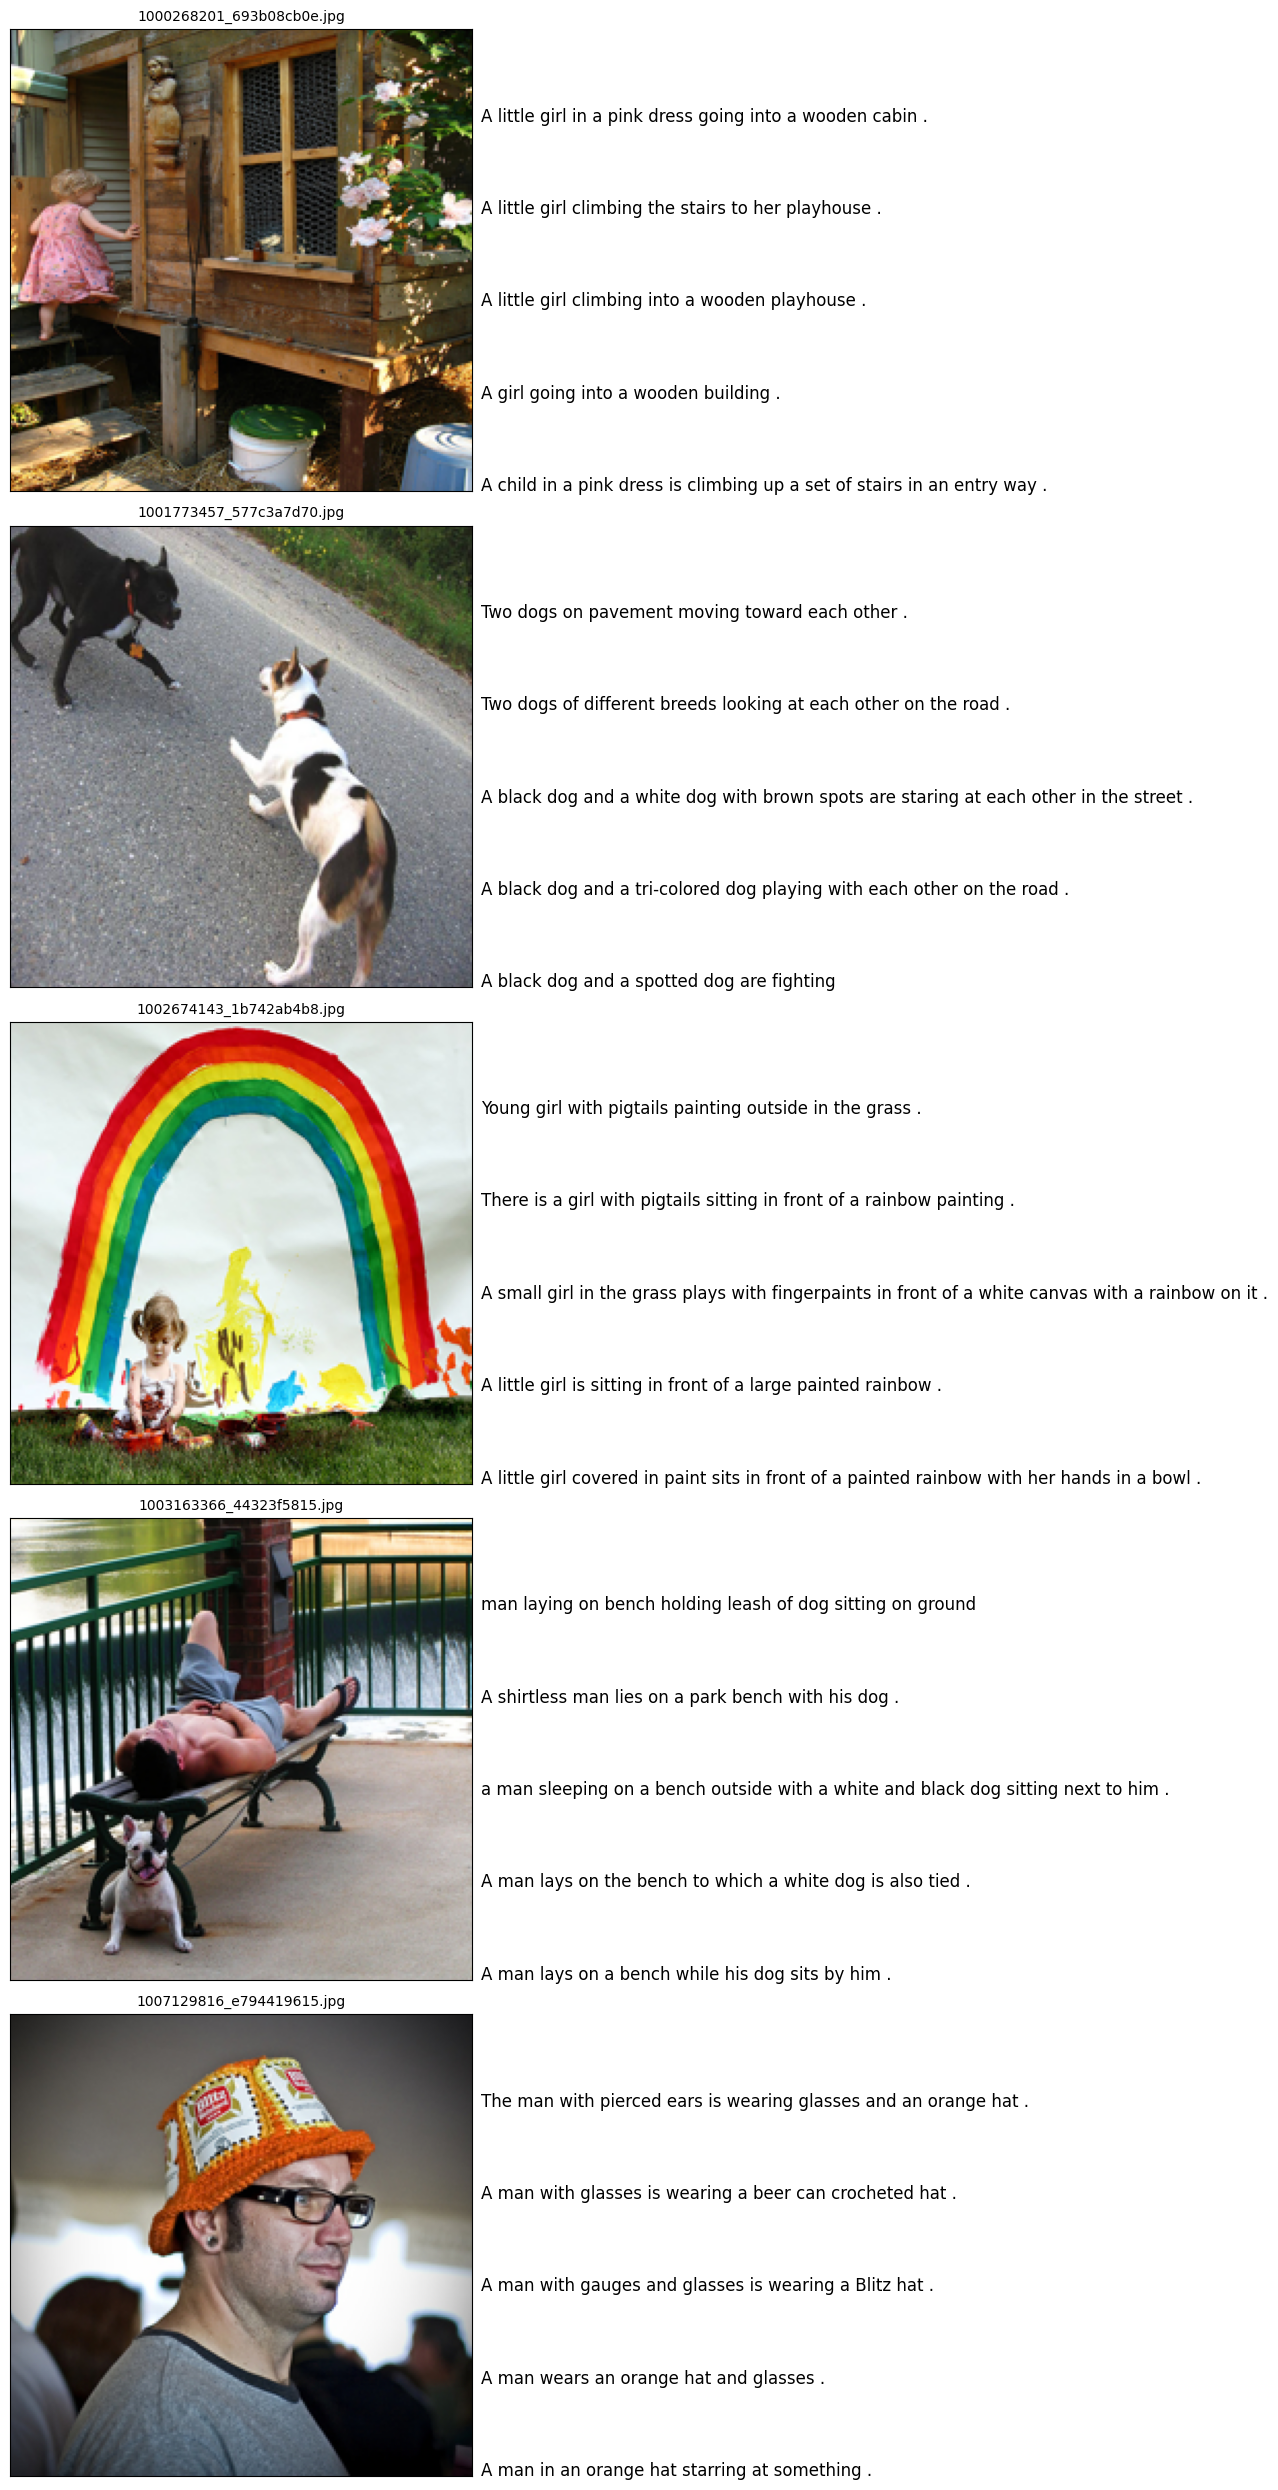

In [6]:

# Get the unique image filenames
unique_images = captions_df['image'].unique()

# Set up the figure for visualization
npic = 5  # Number of images to show
npix = 224  # Size of each image
target_size = (npix, npix)
count = 1

fig = plt.figure(figsize=(15, 25))

# Display the first 5 images with their captions
for jpg_filename in unique_images[:5]:
    # Load and display the image
    filename = f"{image_path}/{jpg_filename}"
    
    try:
        # Get image
        image = Image.open(filename).resize(target_size)
        
        # Display image
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(image)
        ax.set_title(jpg_filename, fontsize=10)
        count += 1
        
        # Get and display captions
        captions = captions_df.loc[captions_df['image'] == jpg_filename, 'caption'].values
        
        ax = fig.add_subplot(npic, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(captions))
        
        for i, caption in enumerate(captions):
            ax.text(0, i, caption, fontsize=12)
        
        count += 1
        
    except Exception as e:
        print(f"Error loading image {jpg_filename}: {e}")
        count += 2  # Skip both the image and caption slots

plt.tight_layout()
plt.show()

In [7]:
# Build vocabulary from all words in captions
vocabulary = []
for caption in captions_df['caption'].values:
    vocabulary.extend(caption.split())

# Get unique words
unique_words = set(vocabulary)
print('Vocabulary Size: %d' % len(unique_words))

Vocabulary Size: 9630


In [8]:
import string

def remove_punctuation(text_original):
    # Create a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text_no_punctuation = text_original.translate(translator)
    return text_no_punctuation

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return text_len_more_than1.strip()

def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return text_no_numeric.strip()

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return text

# Apply text cleaning to all captions
for i, caption in enumerate(captions_df['caption'].values):
    new_caption = text_clean(caption)
    captions_df.at[i, 'caption'] = new_caption


In [9]:
# Build vocabulary from all words in captions
vocabulary = []
for caption in captions_df['caption'].values:
    vocabulary.extend(caption.split())

# Get unique words
unique_words = set(vocabulary)
print('Vocabulary Size: %d' % len(unique_words))

Vocabulary Size: 9473


In [10]:
all_captions = []
for caption in captions_df["caption"].astype(str):
    caption = '<start> ' + caption + ' <end>'
    all_captions.append(caption)

# Display the first 10 formatted captions
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tricolored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> Two dogs of different breeds looking at each other on the road <end>',
 '<start> Two dogs on pavement moving toward each other <end>']

In [11]:
# img_name_vector and all_captions must be aligned: one image path per caption
img_name_vector = []

for img_path, captions in zip(captions_df['image'], captions_df['caption']):
    # If multiple captions per image, ensure you're handling them appropriately
    full_path = f"{image_path}/{img_path}"
    img_name_vector.append(full_path)


# Preview first 10 image paths
print("Sample Image Paths:")
print(img_name_vector[:10])

Sample Image Paths:
['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg', '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg', '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg', '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg', '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg', '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg', '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg', '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg', '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg', '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg']


In [12]:
print(f"len(img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(img_name_vector) : 40455
len(all_captions) : 40455


In [13]:
#Let’s define the image feature extraction model using Xception. 
#We must remember that we do not need to classify the images here, we only need to extract an image vector for our images.
#Hence we remove the softmax layer from the model.
#We must all preprocess all the images to the same size, i.e, 299×299 before feeding them into the model.
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input

# Function to load and preprocess image for Xception (expects 299x299 input)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Xception expects 299x299
    img = preprocess_input(img)  # Xception-specific preprocessing
    return img, image_path

# Load Xception model without the top layer, with ImageNet weights
image_model = Xception(include_top=False, weights='imagenet')

# Extract input and last conv layer output
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# Build model to extract image features
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

# Print summary (optional)
image_features_extract_model.summary()


I0000 00:00:1744535513.117470      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │ 128)                   │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [14]:
len(img_name_vector) == len(all_captions)


True

In [15]:
# Map each image name to the load_image function using tf.data

# Step 1: Get unique list of image paths
encode_train = sorted(set(img_name_vector))  # all_img_name_vector must be defined earlier

# Step 2: Create a TensorFlow dataset from image paths
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Step 3: Map each image path to the load_image function
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
#We extract the features and store them in the respective .npy files and then pass those features through the encoder.NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import time

# Create a directory in writable path
FEATURE_SAVE_DIR = "/kaggle/working/npy_features"
os.makedirs(FEATURE_SAVE_DIR, exist_ok=True)

start_time = time.time()

for img, path in tqdm(image_dataset):
    img = tf.expand_dims(img, axis=0)
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, 
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    # Extract file name from path and save to /kaggle/working/npy_features
    filename = os.path.basename(path.numpy().decode("utf-8"))
    feature_path = os.path.join(FEATURE_SAVE_DIR, filename.replace('.jpg', '.npy'))

    np.save(feature_path, batch_features[0].numpy())

end_time = time.time()
print(f"\n✅ Features saved to /kaggle/working/npy_features in {end_time - start_time:.2f} seconds.")


100%|██████████| 8091/8091 [14:31<00:00,  9.28it/s]


✅ Features saved to /kaggle/working/npy_features in 871.70 seconds.


In [16]:
#Next, we tokenize the captions and build a vocabulary of all the unique words in the data.
#We will also limit the vocabulary size to the top 5000 words to save memory. 
#We will replace words not in vocabulary with the token < unk >

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Limit vocabulary to top 5000 words; replace out-of-vocab words with <unk>
top_k = 5000
tokenizer = Tokenizer(num_words=top_k,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Fit tokenizer on your captions
tokenizer.fit_on_texts(all_captions)  # all_captions must be defined earlier with <start> and <end> tokens

# Convert text captions to sequences of integers
train_seqs = tokenizer.texts_to_sequences(all_captions)

# Add <pad> token explicitly
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Pad sequences to the max length (post-padding ensures trailing zeros)
cap_vector = pad_sequences(train_seqs, padding='post')


In [28]:
train_seqs[:3]

[[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, 4, 28, 1, 692, 3],
 [2, 19, 313, 64, 193, 117, 3],
 [2, 40, 19, 119, 64, 193, 2423, 3]]

In [29]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)


In [30]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 34 : 2


In [22]:
# Save
token_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(token_json)


In [24]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Correct loading method
with open("tokenizer.json", "r") as f:
    tokenizer_json = f.read()

tokenizer = tokenizer_from_json(tokenizer_json)


In [21]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [18]:
#Next, Create training and validation sets using an 80-20 split:

img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49


In [20]:
# let’s create a tf.data dataset to use for training our model.
import tensorflow as tf
import numpy as np

def map_func(img_name, cap):
    filename = img_name.decode('utf-8')
    filename = os.path.basename(filename).replace('.jpg', '.npy')
    feature_path = os.path.join("/kaggle/working/npy_features", filename)
    img_tensor = np.load(feature_path)
    return img_tensor, cap


# Create a tf.data.Dataset from training image paths and caption vectors
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Map each image path + caption using numpy_function (runs in parallel)
dataset = dataset.map(
    lambda img_name, cap: tf.numpy_function(
        map_func, [img_name, cap], [tf.float32, tf.int32]
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle, batch, and prefetch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
class Xception_Encoder(tf.keras.Model):
    """
    This encoder receives features extracted from the Xception model and
    passes them through a Fully Connected (Dense) layer to project them
    into a lower-dimensional embedding space suitable for attention.
    """
    def __init__(self, embedding_dim):
        super(Xception_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)  # Project features to embedding_dim
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [22]:
def rnn_type(units):
    return tf.keras.layers.LSTM(
        units,
        return_sequences=True,
        return_state=True,
        recurrent_initializer='glorot_uniform'
    )


In [23]:
#Next, define the RNN Decoder with Bahdanau Attention:

'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Use LSTM as the RNN layer
        self.lstm = rnn_type(self.units)

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Bahdanau Attention
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden[0], 1)  # Use hidden state h only for attention

        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # LSTM expects a tuple: (hidden_state, cell_state)
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.dropout(x)
        x = self.batchnorm(x)
        x = self.fc2(x)

        return x, [state_h, state_c], attention_weights

    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]



encoder = Xception_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)  


In [24]:
# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Loss function (ignores padding)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
    # real: true word indices, pred: predicted logits
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # ignore <pad> = 0
    loss_ = loss_object(real, pred)

    # Apply mask to ignore pad tokens
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [25]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [110]:
import time

EPOCHS = 20
loss_plot = []

# Optional: infer this if not set
num_steps = len(img_name_train) // BATCH_SIZE

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
            ))

    # Store average epoch loss
    loss_plot.append(total_loss / num_steps)

    print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.7779
Epoch 1 Batch 100 Loss 1.5784
Epoch 1 Batch 200 Loss 1.3824
Epoch 1 Batch 300 Loss 1.2452
Epoch 1 Batch 400 Loss 1.1634
Epoch 1 Batch 500 Loss 1.0950
Epoch 1 Loss 1.347823
Time taken for 1 epoch 137.8508985042572 sec

Epoch 2 Batch 0 Loss 1.0583
Epoch 2 Batch 100 Loss 1.1277
Epoch 2 Batch 200 Loss 1.1495
Epoch 2 Batch 300 Loss 1.0896
Epoch 2 Batch 400 Loss 0.9074
Epoch 2 Batch 500 Loss 0.9349
Epoch 2 Loss 1.025950
Time taken for 1 epoch 81.06820821762085 sec

Epoch 3 Batch 0 Loss 0.8954
Epoch 3 Batch 100 Loss 0.9232
Epoch 3 Batch 200 Loss 0.8769
Epoch 3 Batch 300 Loss 0.7864
Epoch 3 Batch 400 Loss 0.8281
Epoch 3 Batch 500 Loss 0.7680
Epoch 3 Loss 0.910048
Time taken for 1 epoch 81.08047795295715 sec

Epoch 4 Batch 0 Loss 0.7643
Epoch 4 Batch 100 Loss 0.7897
Epoch 4 Batch 200 Loss 0.7938
Epoch 4 Batch 300 Loss 0.7845
Epoch 4 Batch 400 Loss 0.7554
Epoch 4 Batch 500 Loss 0.7362
Epoch 4 Loss 0.824379
Time taken for 1 epoch 80.97889542579651 sec

Epoch 5 Batch 0 

In [3]:
# Save encoder and decoder weights
encoder.save_weights("/kaggle/working/encoder.weights.h5")
decoder.save_weights("/kaggle/working/decoder.weights.h5")


NameError: name 'encoder' is not defined

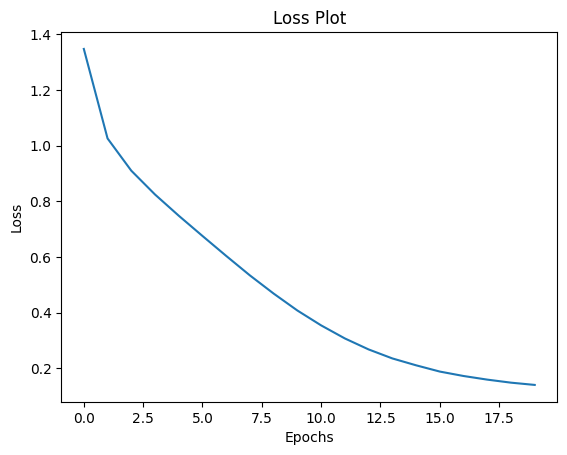

In [113]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

✅ Encoder & Decoder weights loaded successfully.


I0000 00:00:1744536148.553687      96 service.cc:148] XLA service 0x7e72ace20950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744536148.554408      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1744536151.126268      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



📝 Caption: little girl with pink cloth up from wooden walkway in wooden room
⏱️ Time taken: 4.51 sec


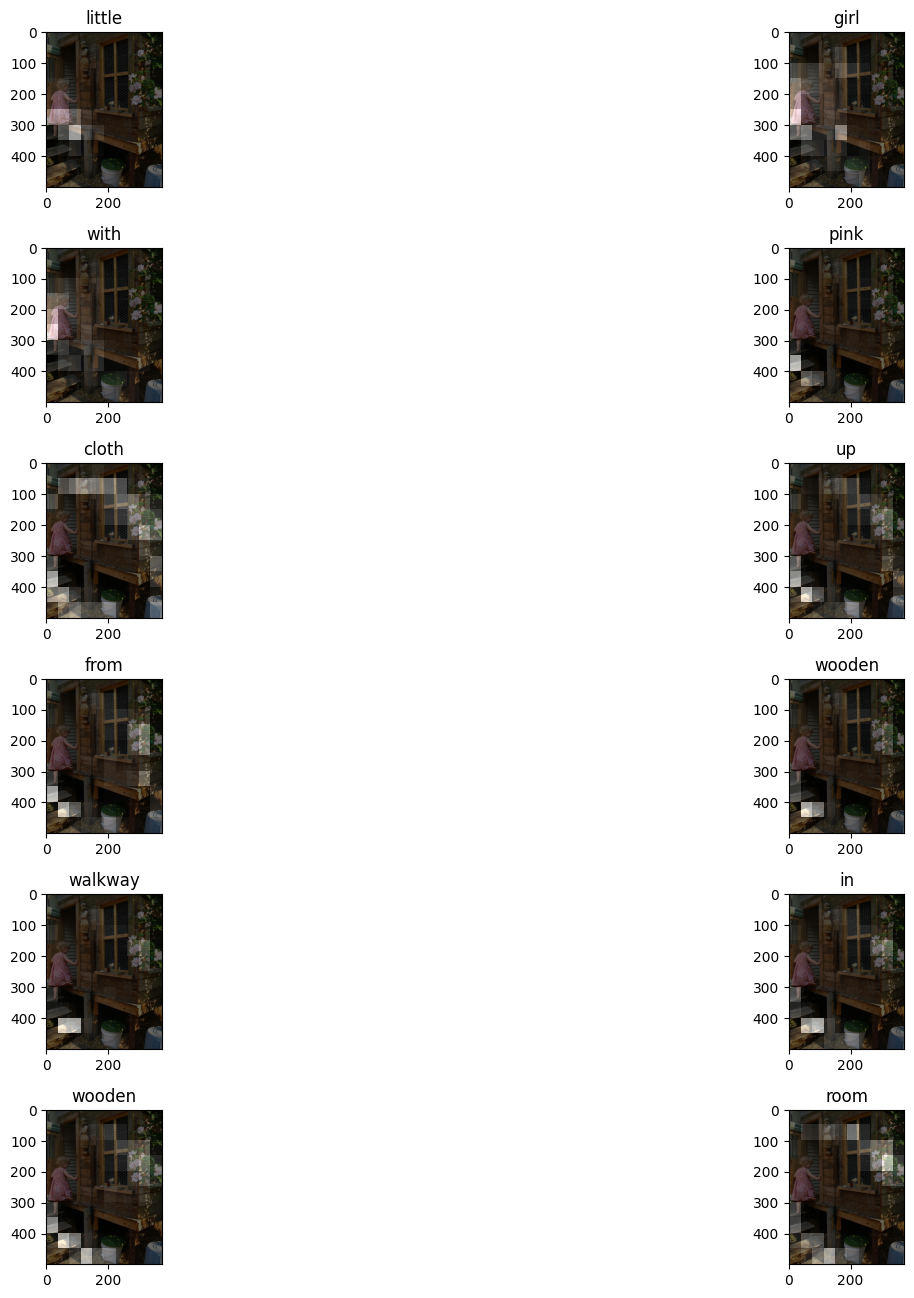

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpk78vcu7j.PNG'


In [31]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf

# ==== Load weights ====
_ = encoder(tf.random.normal((1, 100, 2048)))  # initialize encoder
_ = decoder(tf.constant([[tokenizer.word_index['<start>']]]),
            tf.random.normal((1, 100, embedding_dim)),
            decoder.reset_state(1))  # initialize decoder

encoder.load_weights("/kaggle/input/encoder/other/default/1/encoder.weights.h5")
decoder.load_weights("/kaggle/input/decoder/other/default/1/decoder.weights.h5")
print("✅ Encoder & Decoder weights loaded successfully.")

# ==== Xception feature extractor ====
xception = Xception(include_top=False, weights='imagenet')
feature_extractor = tf.keras.Model(inputs=xception.input, outputs=xception.output)

# ==== Evaluate function ====
def evaluate(image_path):
    attention_plot = np.zeros((max_length, 100))

    image = Image.open(image_path).convert("RGB").resize((299, 299))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    features = feature_extractor.predict(image)
    features = tf.reshape(features, (1, -1, 2048))
    features = encoder(features)

    hidden = decoder.reset_state(1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[i] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = tokenizer.index_word.get(predicted_id, '<unk>')

        if predicted_word == '<end>':
            break
        result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# ==== Plot attention ====
def plot_attention(image_path, result, attention_plot):
    image = np.array(Image.open(image_path).convert("RGB"))
    fig = plt.figure(figsize=(15, 15))
    len_result = len(result)

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (10, 10))
        ax = fig.add_subplot(len_result // 2 + 1, 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# ==== Generate caption ====
image_path = "/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg"  # 🔁 Replace with your image path
start = time.time()

result, attention_plot = evaluate(image_path)

# Clean caption
caption = ' '.join([word for word in result if word not in ['<end>', '<unk>']])
print(f"\n📝 Caption: {caption}")
print(f"⏱️ Time taken: {round(time.time() - start, 2)} sec")

# Show image and attention
plot_attention(image_path, result, attention_plot)
Image.open(image_path).show()


In [123]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set this globally before evaluate()
attention_features_shape = 100  # for Xception (10x10 features)

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Xception input size
    img = tf.keras.applications.xception.preprocess_input(img)
    return img

# Evaluate a single image and return predicted caption + attention
def evaluate(image_path):
    attention_plot = np.zeros((max_length, attention_features_shape))  # (max_len, 100)

    hidden = decoder.reset_state(batch_size=1)

    # Preprocess image and extract features
    temp_input = tf.expand_dims(load_and_preprocess_image(image_path), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_weights = tf.reshape(attention_weights, (-1, ))  # (100,)
        attention_plot[i] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = tokenizer.index_word.get(predicted_id, "<unk>")
        result.append(predicted_word)

        if predicted_word == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [124]:
def plot_attention(image_path, result, attention_plot):
    temp_image = np.array(Image.open(image_path))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (10, 10))
        ax = fig.add_subplot(len_result//2 + 1, len_result//2 + 1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


BLEU Score: 0.00
Real Caption: there is an asian man and woman both smiling and he is pointing at her
Predicted Caption: woman and woman smile for the camera


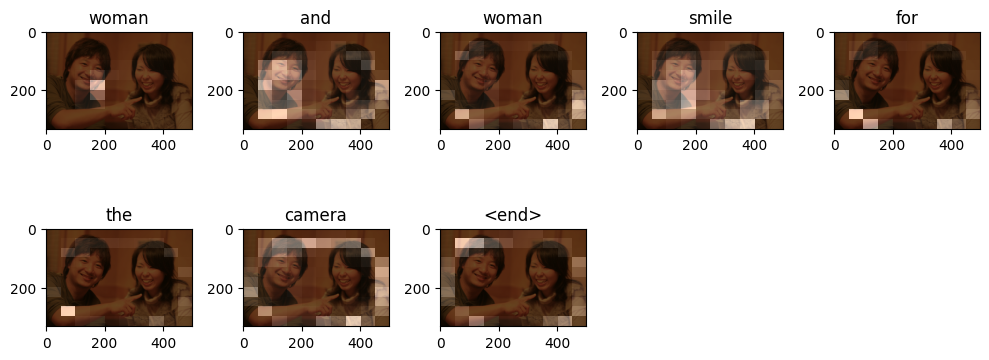

In [125]:
import random
from nltk.translate.bleu_score import sentence_bleu

# Pick a random validation image
rid = random.randint(0, len(img_name_val))
image_path = img_name_val[rid]

# Real caption
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption_clean = real_caption.replace('<start>', '').replace('<end>', '').strip()

# Predicted caption + attention
result, attention_plot = evaluate(image_path)
pred_caption = ' '.join([word for word in result if word not in ['<start>', '<end>', '<unk>']])

# BLEU evaluation
reference = [real_caption_clean.split()]
candidate = pred_caption.split()
score = sentence_bleu(reference, candidate)

# Output
print(f"BLEU Score: {score * 100:.2f}")
print("Real Caption:", real_caption_clean)
print("Predicted Caption:", pred_caption)

# Visualize attention
plot_attention(image_path, result, attention_plot)


Real Caption: two wet boys in swim trunks run
Prediction Caption: two boys play on the sidewalk


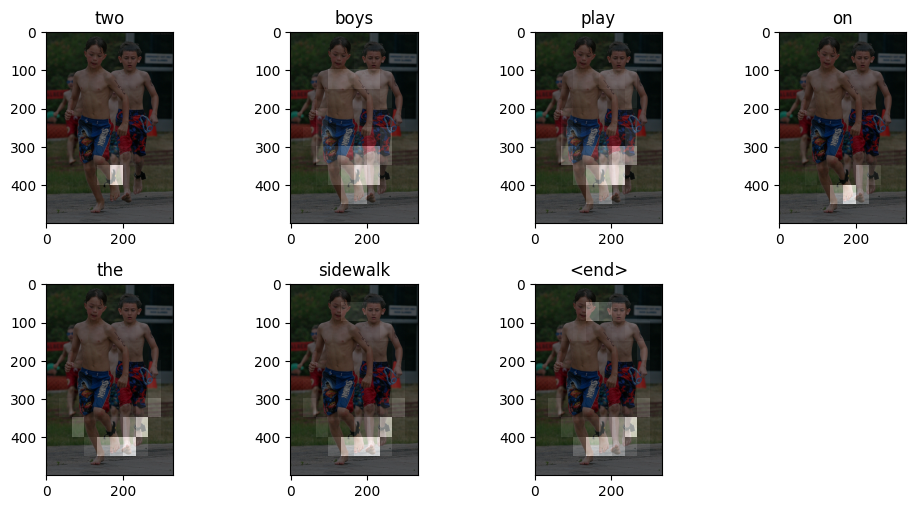

time took to Predict: 1 sec


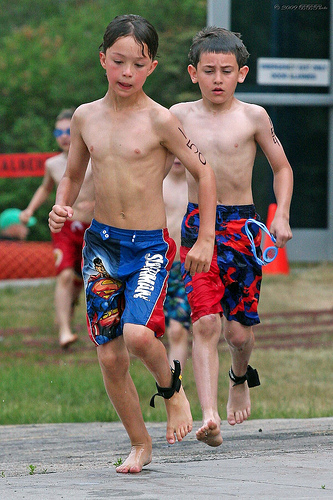

In [126]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)


